In [2]:
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)
from peft import LoraConfig, get_peft_model, TaskType
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Configuration de la seed pour la reproductibilité
torch.manual_seed(42)
np.random.seed(42)

# Ton modèle (DistilBERT est très bien pour ça)
model_name = "distilbert-base-uncased"

In [3]:
def compute_metrics_multilabel(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))

    # Seuil de décision (0.4 pour être un peu plus sensible)
    predictions = (probs > 0.5).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='micro', zero_division=0
    )
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [4]:
# 1. Chargement de tes données (je simule avec tes noms de variables)
# Assure-toi que df_equi contient tes données
df = pd.read_csv("df_non_biaisé.csv") # ou ton dataframe nettoyé

# 2. Création du texte d'entrée (Ton prompt était très bien, on le garde)
def construire_prompt(row):
    return (
        f"Employee Profile: {row.get('sex', 'N/A')}, {row.get('age_group', 'N/A')}. "
        f"History: {row.get('mental_health_history', 'None')}. "
        f"Job: {row.get('profession', 'N/A')} ({row.get('work_mode', 'N/A')}). "
        f"Workload: {row.get('work_hours', 0)}h, {row.get('meetings_count', 0)} meetings. "
        f"Stress: {row.get('stress_level', 0)}/10. Sleep: {row.get('sleep_hours', 0)}h. "
        f"BMI: {row.get('baseline_bmi', 0)}. Diet: {row.get('diet_quality', 'N/A')}."
    )

df['text'] = df.apply(construire_prompt, axis=1)

# 3. Création des Labels (Format One-Hot Encoding)
targets = ['intervention_vacation', 'intervention_diet_coaching', 'intervention_exercise_plan']
# On convertit en liste de FLOATS (important pour BCEWithLogitsLoss)
df['labels'] = df[targets].values.tolist()
df['labels'] = df['labels'].apply(lambda x: [float(i) for i in x])

# 4. Split Train/Test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 5. Conversion en Dataset Hugging Face
train_dataset = Dataset.from_pandas(train_df[['text', 'labels']])
test_dataset = Dataset.from_pandas(test_df[['text', 'labels']])

# 6. Tokenization
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples['text'], 
        padding="max_length", 
        truncation=True, 
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# IMPORTANT : Définir le format pour PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print("✅ Données prêtes.")
print(f"Exemple de label: {train_dataset[0]['labels']} (Doit être des float, ex: tensor([1., 0., 0.]))")

Map: 100%|██████████| 220/220 [00:00<00:00, 31357.15 examples/s]

✅ Données prêtes.
Exemple de label: tensor([1., 0., 1.]) (Doit être des float, ex: tensor([1., 0., 0.]))


In [6]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Recalcul des poids par sécurité
num_positives = train_df[targets].sum().values
num_negatives = len(train_df) - num_positives
pos_weights_tensor = torch.tensor(num_negatives / (num_positives + 1e-5), dtype=torch.float).to(device)

class WeightedTrainer(Trainer):
    # --- CORRECTION ICI : Ajout de **kwargs ---
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Fonction de perte pondérée
        # On s'assure que les poids sont sur le même device que les logits
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor.to(logits.device))
        
        loss = loss_fct(logits, labels.float())
        
        return (loss, outputs) if return_outputs else loss

print("✅ Classe WeightedTrainer mise à jour.")

✅ Classe WeightedTrainer mise à jour.


In [7]:
print("\n🚀 Configuration du Full Fine-Tuning...")

# 1. Chargement d'un modèle vierge
model_ft = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    problem_type="multi_label_classification"
)

# 2. Arguments d'entraînement
# Note : LR plus faible (2e-5) car on touche à tous les poids
training_args_ft = TrainingArguments(
    output_dir="./results_ft",
    num_train_epochs=10,             # 10 époques pour bien converger
    learning_rate=2e-5,              # Plus doux que LoRA
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    weight_decay=0.01,
    save_total_limit=1,
    logging_steps=10
)

# 3. Création du Trainer (On réutilise votre WeightedTrainer)
trainer_ft = WeightedTrainer(
    model=model_ft,
    args=training_args_ft,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics_multilabel,
)

print("🔥 Lancement du Fine-Tuning Complet...")
trainer_ft.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Configuration du Full Fine-Tuning...
🔥 Lancement du Fine-Tuning Complet...


/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.155500,1.110407,0.095455,0.331933,0.217033,0.705357
2,0.947800,0.986068,0.272727,0.435233,0.306569,0.750000
3,0.955800,0.951610,0.290909,0.441624,0.308511,0.776786
4,0.846700,0.909874,0.304545,0.468750,0.330882,0.803571
5,0.788200,0.899396,0.350000,0.485014,0.349020,0.794643
6,0.742300,0.901389,0.368182,0.487535,0.353414,0.785714
7,0.748900,0.897675,0.363636,0.486188,0.352000,0.785714
8,0.819700,0.909651,0.359091,0.484848,0.350598,0.785714
9,0.701700,0.904388,0.363636,0.486188,0.352000,0.785714
10,0.812800,0.903380,0.363636,0.486188,0.352000,0.785714


/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now

TrainOutput(global_step=550, training_loss=0.8611728971654719, metrics={'train_runtime': 217.6767, 'train_samples_per_second': 40.335, 'train_steps_per_second': 2.527, 'total_flos': 290771125447680.0, 'train_loss': 0.8611728971654719, 'epoch': 10.0})

In [8]:
print("\n🔵 Configuration LoRA...")

from peft import LoraConfig, get_peft_model, TaskType

# On recharge le modèle de base propre
model_lora = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=3, 
    problem_type="multi_label_classification"
)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=32,           # Augmenté de 8 ou 16 à 32 (Plus de "neurones" pour apprendre)
    lora_alpha=64,  # Augmenté (Généralement alpha = 2 * r) -> Amplifie l'impact de l'apprentissage
    lora_dropout=0.1,
    bias="none",
    # Cible TOUS les modules linéaires de DistilBERT, pas juste l'attention
    # Cela donne beaucoup plus de flexibilité au modèle
    target_modules=["q_lin", "v_lin", "k_lin", "out_lin", "classifier"] 
)

model_lora = get_peft_model(model_lora, lora_config)
model_lora.print_trainable_parameters() # Vérifiez que vous avez environ 1% à 3% de paramètres entraînables

training_args_lora = TrainingArguments(
    output_dir="./results_lora",
    num_train_epochs=10,            # 5 n'est pas assez pour sortir du plateau
    learning_rate=5e-4,             # Plus agressif que le 2e-5 habituel
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    weight_decay=0.01,
    save_total_limit=1,
    logging_steps=10
)

# Lancez avec le WeightedTrainer
trainer_lora = WeightedTrainer( # <--- Utilisez bien WeightedTrainer
    model=model_lora,
    args=training_args_lora,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics_multilabel,
)

print("🚀 Lancement du LoRA Boosté...")
trainer_lora.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔵 Configuration LoRA...
trainable params: 1,772,547 || all params: 68,728,326 || trainable%: 2.5791
🚀 Lancement du LoRA Boosté...


/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.104400,1.025701,0.181818,0.380313,0.253731,0.758929
2,0.915600,0.983958,0.309091,0.456410,0.320144,0.794643
3,0.897000,1.014439,0.295455,0.434180,0.292835,0.839286
4,0.884000,1.000283,0.290909,0.446078,0.307432,0.812500
5,0.853100,1.029458,0.331818,0.444444,0.315789,0.750000
6,0.814400,1.013839,0.413636,0.493976,0.372727,0.732143
7,0.816000,1.014103,0.350000,0.476190,0.338346,0.803571
8,0.863600,1.043542,0.409091,0.506098,0.384259,0.741071
9,0.739000,1.011065,0.340909,0.474667,0.338403,0.794643
10,0.802400,1.019459,0.354545,0.487671,0.351779,0.794643


/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now

TrainOutput(global_step=550, training_loss=0.8665749619223855, metrics={'train_runtime': 181.8078, 'train_samples_per_second': 48.293, 'train_steps_per_second': 3.025, 'total_flos': 302723480770560.0, 'train_loss': 0.8665749619223855, 'epoch': 10.0})

In [9]:
import torch
import torch.nn as nn

# 1. Configuration du Device et des Poids
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# On s'assure que les poids sont bien calculés et sur le bon device
# (Copiez cette partie si vous ne l'avez plus en mémoire)
num_positives = train_df[targets].sum().values
num_negatives = len(train_df) - num_positives
pos_weights_tensor = torch.tensor(num_negatives / (num_positives + 1e-5), dtype=torch.float).to(device)

# 2. Préparation du Professeur (Teacher)
# On s'assure qu'il est sur le bon device et figé
teacher_model = model_lora 
teacher_model.to(device)
teacher_model.eval()

# 3. Préparation de l'Élève (Student)
student_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    problem_type="multi_label_classification"
)
student_model.to(device)

# 4. Trainer de Distillation Corrigé
class DistillationMultiLabelTrainer(Trainer):
    def __init__(self, teacher_model=None, temperature=1.0, alpha=0.5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        self.temperature = temperature
        self.alpha = alpha
        self.mse_loss = nn.MSELoss() 

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # A. Récupération des données
        labels = inputs.get("labels")
        
        # B. Passage dans l'Élève (Une seule fois !)
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits
        
        # C. Passage dans le Professeur (Sans gradient)
        with torch.no_grad():
            teacher_outputs = self.teacher(**inputs)
            teacher_logits = teacher_outputs.logits

        # D. Calcul de la Loss "Vérité Terrain" (Weighted BCE)
        # On réimplémente ici la logique de WeightedTrainer pour éviter d'appeler super()
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor.to(student_logits.device))
        loss_ce = loss_fct(student_logits, labels.float())

        # E. Calcul de la Loss de Distillation (MSE sur les logits)
        loss_distill = self.mse_loss(student_logits, teacher_logits)

        # F. Combinaison
        final_loss = (self.alpha * loss_ce) + ((1 - self.alpha) * loss_distill)

        return (final_loss, student_outputs) if return_outputs else final_loss

# 5. Arguments & Lancement
training_args_distill = TrainingArguments(
    output_dir="./results_distill",
    num_train_epochs=10,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    weight_decay=0.01,
    logging_steps=10,
    save_total_limit=1,
    report_to="none"
)

trainer_distill = DistillationMultiLabelTrainer(
    model=student_model,
    teacher_model=teacher_model,
    alpha=0.5, 
    args=training_args_distill,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics_multilabel,
)

print("🧪 Relancement de la Distillation (Version Corrigée MPS)...")
trainer_distill.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧪 Relancement de la Distillation (Version Corrigée MPS)...


/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.317900,1.097631,0.354545,0.417391,0.309013,0.642857
2,0.593000,0.690005,0.350000,0.464865,0.333333,0.767857
3,0.512800,0.586361,0.354545,0.478723,0.340909,0.803571
4,0.450000,0.577741,0.413636,0.507645,0.386047,0.741071
5,0.414100,0.552343,0.409091,0.506098,0.384259,0.741071
6,0.394900,0.546442,0.413636,0.509202,0.387850,0.741071
7,0.396500,0.538021,0.413636,0.506098,0.384259,0.741071
8,0.441200,0.532280,0.390909,0.493075,0.357430,0.794643
9,0.383100,0.528645,0.436364,0.513932,0.393365,0.741071
10,0.440400,0.527423,0.431818,0.510769,0.389671,0.741071


/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now

TrainOutput(global_step=550, training_loss=0.6735460896925493, metrics={'train_runtime': 341.7652, 'train_samples_per_second': 25.69, 'train_steps_per_second': 1.609, 'total_flos': 290771125447680.0, 'train_loss': 0.6735460896925493, 'epoch': 10.0})

In [10]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, multilabel_confusion_matrix, classification_report

def evaluer_modele_multilabel(model, test_df, tokenizer, nom_modele, threshold=0.5):
    """
    Version OPTIMISÉE qui accepte un seuil personnalisé.
    """
    print(f"\n🔍 Évaluation de : {nom_modele}")
    print(f"   👉 Seuil de décision : {threshold}")
    print("-" * 60)

    # Gestion du Device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()

    predictions = []
    true_labels = []

    print("   Calcul des prédictions en cours...")
    
    with torch.no_grad():
        for idx, row in test_df.iterrows():
            text = row['text']
            # Gestion des labels (String -> List)
            if isinstance(row['labels'], str):
                import ast
                true_labels.append(ast.literal_eval(row['labels']))
            else:
                true_labels.append(row['labels'])

            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding="max_length").to(device)
            outputs = model(**inputs)
            
            # Sigmoid + Seuil Personnalisé
            probs = torch.sigmoid(outputs.logits)
            
            # C'EST ICI QUE ÇA CHANGE : On utilise la variable 'threshold'
            pred = (probs > threshold).int().cpu().numpy()[0] 
            predictions.append(pred)

    y_true = np.array(true_labels)
    y_pred = np.array(predictions)

    # Calcul des métriques
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='micro', zero_division=0
    )

    print(f"   Accuracy  : {accuracy:.4f}")
    print(f"   Precision : {precision:.4f}")
    print(f"   Recall    : {recall:.4f}")
    print(f"   F1-Score  : {f1:.4f}")

    return {
        'name': nom_modele,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'y_true': y_true,
        'y_pred': y_pred
    }

In [11]:
result_fine_tuned = evaluer_modele_multilabel(
    model=model_ft,
    test_df=test_df,
    tokenizer=tokenizer,
    nom_modele="Modèle Fine-Tuned avec Weighted Loss"
)


🔍 Évaluation de : Modèle Fine-Tuned avec Weighted Loss
   👉 Seuil de décision : 0.5
------------------------------------------------------------
   Calcul des prédictions en cours...
   Accuracy  : 0.3682
   Precision : 0.3534
   Recall    : 0.7857
   F1-Score  : 0.4875


In [12]:
model_lora_merged = model_lora.merge_and_unload()
result_lora = evaluer_modele_multilabel(
    model=model_lora_merged,
    test_df=test_df,
    tokenizer=tokenizer,
    nom_modele="Modèle LoRA Fine-Tuned"
)


🔍 Évaluation de : Modèle LoRA Fine-Tuned
   👉 Seuil de décision : 0.5
------------------------------------------------------------
   Calcul des prédictions en cours...
   Accuracy  : 0.4091
   Precision : 0.3843
   Recall    : 0.7411
   F1-Score  : 0.5061


In [13]:
result_distill = evaluer_modele_multilabel(
    model=student_model,
    test_df=test_df,
    tokenizer=tokenizer,
    nom_modele="Modèle Distillé Offline"
)


🔍 Évaluation de : Modèle Distillé Offline
   👉 Seuil de décision : 0.5
------------------------------------------------------------
   Calcul des prédictions en cours...
   Accuracy  : 0.4364
   Precision : 0.3934
   Recall    : 0.7411
   F1-Score  : 0.5139


📊 TABLEAU DES RÉSULTATS :


,Accuracy,Précision,Rappel (Recall),F1-Score
Fine-tuné,36.82%,35.34%,78.57%,48.75%
LoRA,40.91%,38.43%,74.11%,50.61%
Distillé,43.64%,39.34%,74.11%,51.39%


<Figure size 1400x700 with 0 Axes>

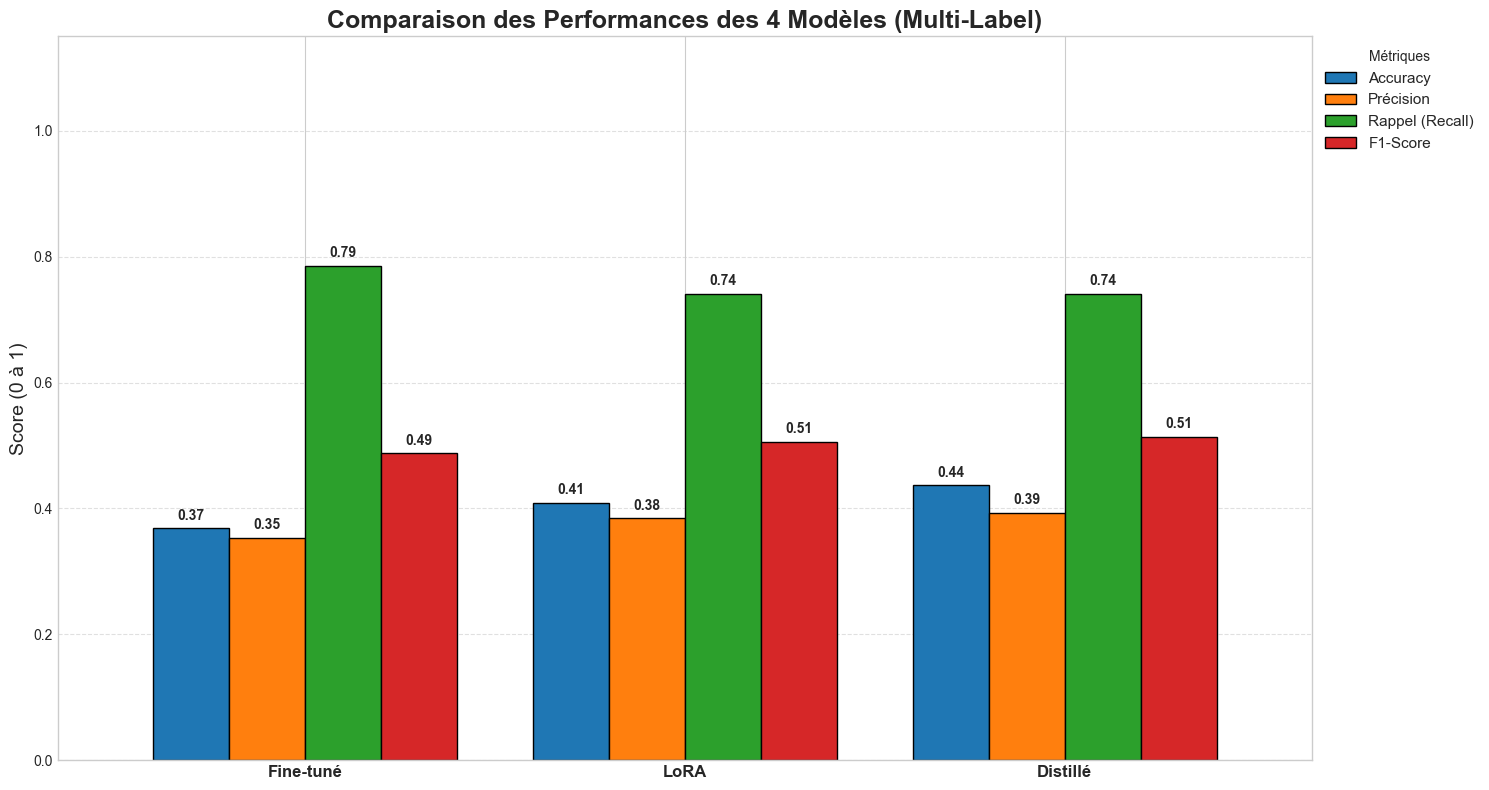

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==============================================================================
# 1. PRÉPARATION DES DONNÉES
# ==============================================================================

# Récupération des dictionnaires de résultats
# (Assurez-vous d'avoir exécuté les cellules d'évaluation précédentes)
data = {
    'Fine-tuné': result_fine_tuned,
    'LoRA': result_lora,
    'Distillé': result_distill
}

# Création d'un DataFrame pour faciliter l'affichage
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
metrics_labels = ['Accuracy', 'Précision', 'Rappel (Recall)', 'F1-Score']

# Extraction des valeurs
rows = []
for model_name, metrics in data.items():
    row = [metrics.get(m, 0) for m in metrics_to_plot]
    rows.append(row)

df_results = pd.DataFrame(rows, columns=metrics_labels, index=data.keys())

# Affichage du tableau de données
print("📊 TABLEAU DES RÉSULTATS :")
display(df_results.style.background_gradient(cmap='Blues', axis=0).format("{:.2%}"))

# ==============================================================================
# 2. GRAPHIQUE DE COMPARAISON
# ==============================================================================
plt.figure(figsize=(14, 7))
plt.style.use('seaborn-v0_8-whitegrid')

# Création du graphique en barres groupées
ax = df_results.plot(kind='bar', figsize=(15, 8), width=0.8, edgecolor='black')

# Esthétique
plt.title('Comparaison des Performances des 4 Modèles (Multi-Label)', fontsize=18, fontweight='bold')
plt.ylabel('Score (0 à 1)', fontsize=14)
plt.ylim(0, 1.15)  # Un peu de marge pour la légende
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.legend(title="Métriques", bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Ajout des valeurs exactes au-dessus des barres
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=4, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

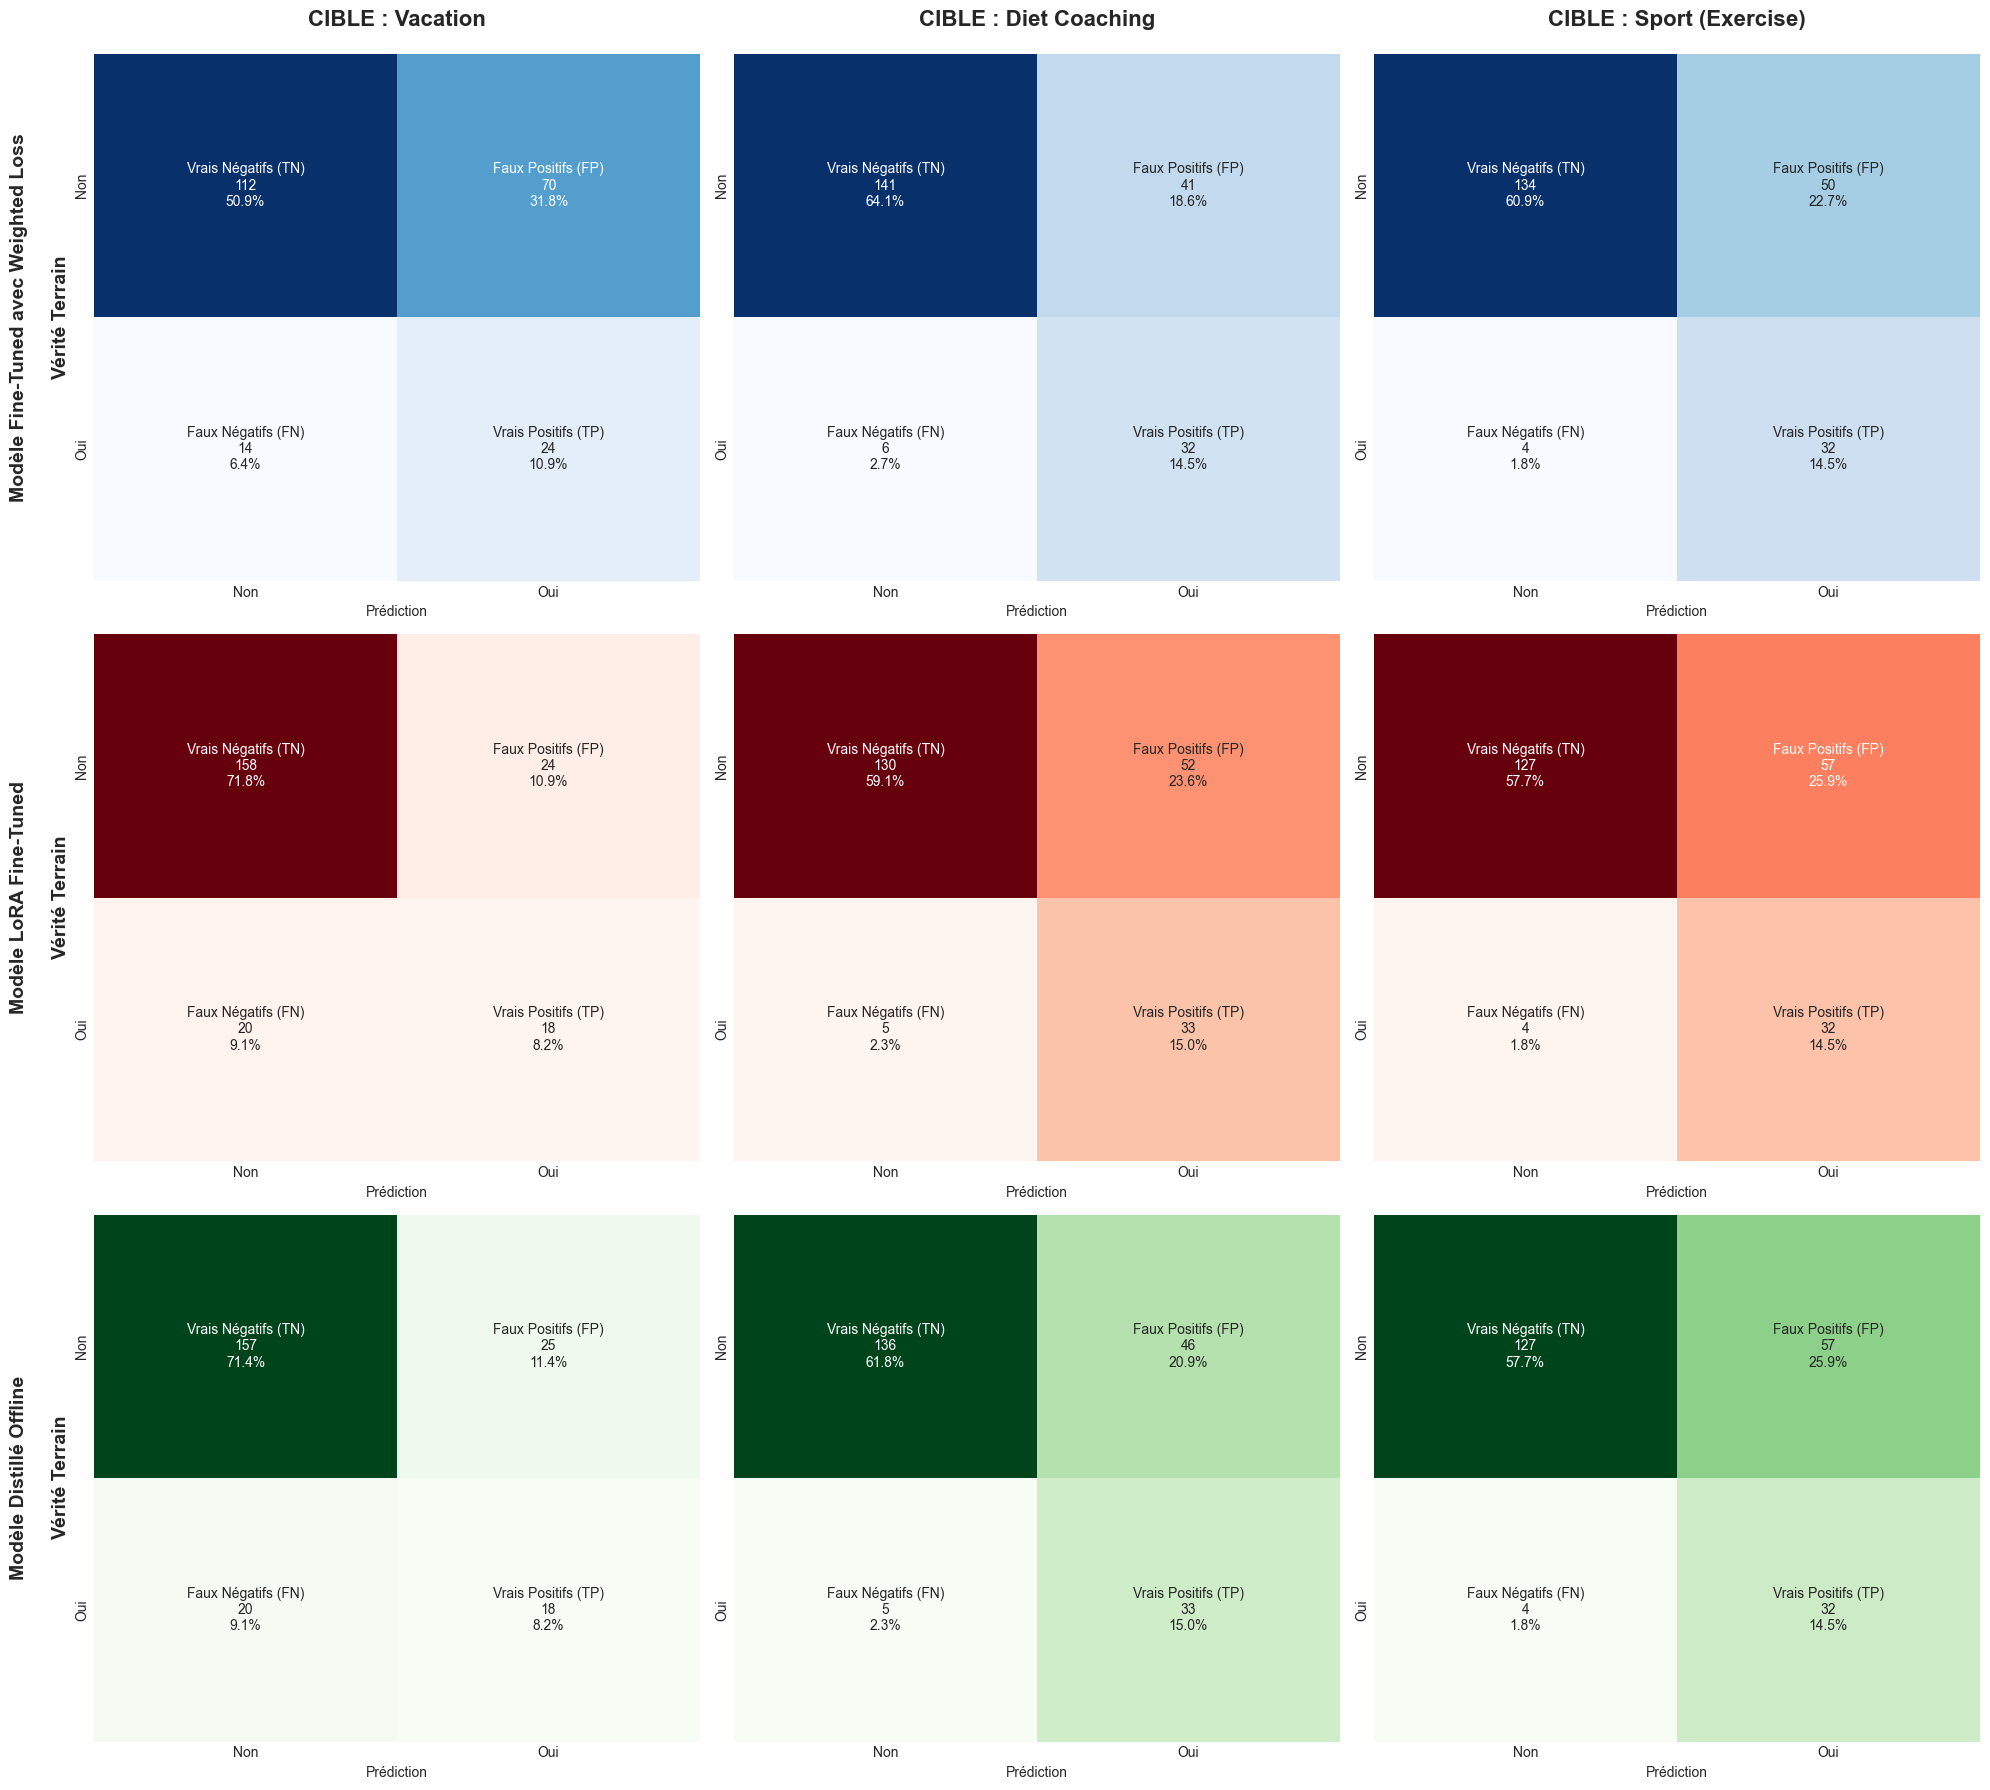

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

# 1. Liste des résultats à comparer
# Assurez-vous que ces variables existent (résultats de vos évaluations précédentes)
models_to_plot = [result_fine_tuned, result_lora, result_distill]

# Noms des colonnes cibles
target_names = ['Vacation', 'Diet Coaching', 'Sport (Exercise)']

# 2. Configuration de la figure (3 lignes pour les modèles, 3 colonnes pour les classes)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 18))

# Titre global (optionnel, peut être retiré pour plus de clarté)
# fig.suptitle('Comparaison des Matrices de Confusion : FT vs LoRA vs Distillation', fontsize=20, fontweight='bold', y=1.02)

# 3. Boucle sur chaque modèle (Lignes)
for i, result in enumerate(models_to_plot):
    
    # Récupération des données
    y_true = result['y_true']
    y_pred = result['y_pred']
    model_name = result['name']
    
    # Calcul des matrices pour ce modèle
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    
    # Boucle sur chaque classe (Colonnes)
    for j, label in enumerate(target_names):
        ax = axes[i, j] # Sélection du sous-graphique
        cm = mcm[j]
        
        # Création des annotations
        total = cm.sum()
        group_names = ['Vrais Négatifs (TN)', 'Faux Positifs (FP)', 'Faux Négatifs (FN)', 'Vrais Positifs (TP)']
        group_counts = [f"{value:0.0f}" for value in cm.flatten()]
        group_percentages = [f"{value:.1%}" for value in cm.flatten()/total]
        
        labels_annot = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
        labels_annot = np.asarray(labels_annot).reshape(2,2)

        # Heatmap
        # On change la couleur selon le modèle pour bien les distinguer visuellement
        # Bleu pour FT, Rouge pour LoRA, Vert pour Distill
        colormap = ['Blues', 'Reds', 'Greens'][i]
        
        sns.heatmap(cm, annot=labels_annot, fmt='', cmap=colormap, ax=ax, cbar=False,
                    xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
        
        # Titres et Labels
        # Titre de la colonne seulement sur la première ligne
        if i == 0:
            ax.set_title(f'CIBLE : {label}', fontweight='bold', fontsize=16, pad=20)
            
        # Nom du modèle à gauche de la ligne
        if j == 0:
            ax.set_ylabel(f"{model_name}\n\nVérité Terrain", fontweight='bold', fontsize=14)
        else:
            ax.set_ylabel('')
            
        ax.set_xlabel('Prédiction')

plt.tight_layout()
plt.show()

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel

# ==============================================================================
# 1. CONFIGURATION DES CHEMINS
# ==============================================================================
# Ici, on liste les dossiers où vos entraînements précédents ont sauvegardé les fichiers.
saved_models_paths = {
    'Fine-Tuning': "./results_ft/checkpoint-330",          # Dossier du FT complet
    'LoRA': "./results_lora/checkpoint-440",       # Dossier des adaptateurs LoRA
    # Pour la distillation, souvent le meilleur est dans un checkpoint spécifique
    # Mettez ici le chemin affiché dans "Le meilleur checkpoint était..."
    'Distillation': "./results_distill/checkpoint-495" # Exemple, ajustez selon vos logs
}

# 🛑 CHOIX DU MEILLEUR MODÈLE (WINNER)
# D'après vos résultats, c'est LoRA
selected_model_type = "Distillation"  # Changez ici selon votre choix final
selected_path = saved_models_paths[selected_model_type]

print(f"🏆 Modèle sélectionné pour la production : {selected_model_type}")
print(f"📂 Chargement depuis : {selected_path}")

# ==============================================================================
# 2. CHARGEMENT DU TOKENIZER
# ==============================================================================
# On essaie de charger le tokenizer sauvegardé, sinon on reprend celui de base
try:
    tokenizer = AutoTokenizer.from_pretrained(selected_path)
except:
    print("⚠️ Tokenizer non trouvé dans le dossier, chargement depuis distilbert-base-uncased...")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# ==============================================================================
# 3. CHARGEMENT DU MODÈLE (Logique Adaptative)
# ==============================================================================
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

if selected_model_type == "LoRA":
    # --- CAS SPÉCIAL LoRA ---
    # LoRA ne sauvegarde pas tout le modèle, juste les "différences" (adaptateurs).
    # Il faut donc charger le modèle de base vide, puis lui greffer les adaptateurs.
    
    print("⚙️ Reconstruction du modèle LoRA (Base + Adaptateurs)...")
    
    # A. Charger la structure vide
    base_model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=3,
        problem_type="multi_label_classification",
        id2label={0: "Vacation", 1: "Diet", 2: "Sport"},
        label2id={"Vacation": 0, "Diet": 1, "Sport": 2}
    )
    base_model.config.pad_token_id = tokenizer.pad_token_id
    
    # B. Greffer les poids sauvegardés
    model_production = PeftModel.from_pretrained(base_model, selected_path)

else:
    # --- CAS STANDARD (Fine-Tuning ou Distillation) ---
    # Ici, le dossier contient le modèle entier. C'est plus simple.
    print("⚙️ Chargement du modèle complet...")
    
    model_production = AutoModelForSequenceClassification.from_pretrained(
        selected_path,
        num_labels=3,
        problem_type="multi_label_classification"
    )

# Envoi sur la puce Mac (MPS) et passage en mode évaluation
model_production.to(device)
model_production.eval()

print(f"\n✅ {selected_model_type} est chargé et prêt pour l'Assistant RH !")

/Users/antonindoat/Documents/ING5/Ethics/Fine_tuning/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🏆 Modèle sélectionné pour la production : Distillation
📂 Chargement depuis : ./results_distill/checkpoint-495
⚠️ Tokenizer non trouvé dans le dossier, chargement depuis distilbert-base-uncased...
⚙️ Chargement du modèle complet...

✅ Distillation est chargé et prêt pour l'Assistant RH !


In [3]:
import torch
import numpy as np

# ==============================================================================
# 1. FONCTION DE TRANSFORMATION (Dict -> Texte)
# ==============================================================================
def construire_prompt_test(row):
    """
    Transforme un dictionnaire employé en prompt texte, identique à l'entraînement.
    """
    intro = (
        f"Employee Profile: {row.get('sex', 'N/A')}, {row.get('age_group', 'N/A')} group. "
        f"History: Mental health history is {row.get('mental_health_history', 'None')}."
    )
    job = (
        f"Job Context: Works as {row.get('profession', 'N/A')} ({row.get('work_mode', 'N/A')}). "
        f"Workload: {row.get('work_hours', 0)} hours/day, {row.get('meetings_count', 0)} meetings/day. "
        f"Pressure: {row.get('work_pressure', 0)}/10. Satisfaction: {row.get('job_satisfaction', 0)}/10. "
        f"Productivity: {row.get('tasks_completed', 0)} tasks completed."
    )
    mental = (
        f"Mental State: Stress level {row.get('stress_level', 0)}/10 (Perceived: {row.get('perceived_stress_scale', 0)}). "
        f"Mood: {row.get('mood_score', 0)}/10. Anxiety: {row.get('anxiety_score', 0)}/10. Depression: {row.get('depression_score', 0)}/10. "
        f"Sleep: {row.get('sleep_hours', 0)}h/night (Quality: {row.get('sleep_quality', 0)}/10)."
    )
    physique = (
        f"Physical Health: BMI {row.get('baseline_bmi', 0)} (Weight: {row.get('weight_kg', 0)}kg). "
        f"Lifestyle: Diet is '{row.get('diet_quality', 'N/A')}' ({row.get('cheat_meals_count', 0)} cheat meals). "
        f"Activity: {row.get('exercise_habit', 'N/A')}, {row.get('steps_count', 0)} steps/day. "
        f"Caffeine: {row.get('caffeine_mg', 0)}mg."
    )
    
    prompt = (
        f"### Instruction:\n"
        f"Analyze the employee data below and predict necessary HR interventions "
        f"(Vacation, Diet Coaching, Exercise Plan).\n\n"
        f"### Input:\n"
        f"- {intro}\n"
        f"- {job}\n"
        f"- {mental}\n"
        f"- {physique}\n\n"
        f"### Response:"
    )
    return prompt

# ==============================================================================
# 2. FONCTION DE PRÉDICTION
# ==============================================================================
SEUIL_OPTIMAL = 0.50 

labels_map = {
    0: "🏖️ Congés (Vacation)", 
    1: "🥗 Coaching Nutrition (Diet)", 
    2: "🏃 Programme Sportif (Exercise)"
}

def predire_besoins_rh(texte, model, tokenizer, threshold=0.5):
    inputs = tokenizer(texte, return_tensors="pt", truncation=True, padding=True, max_length=512)
    # Envoi sur le bon device (récupéré depuis le modèle)
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    
    probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]
    recommandations = []
    
    print(f"\n📋 Analyse du profil...")
    print("-" * 50)
    
    for i, prob in enumerate(probs):
        is_selected = prob > threshold
        status_icon = "✅ OUI" if is_selected else "❌ NON"
        bar_length = int(prob * 20)
        bar = "█" * bar_length + "░" * (20 - bar_length)
        
        print(f"   {labels_map[i]:<30} | {bar} {prob:.1%} -> {status_icon}")
        
        if is_selected:
            recommandations.append(labels_map[i])
            
    return recommandations

# ==============================================================================
# 3. DONNÉES DE TEST
# ==============================================================================
profils_test = [
# 1. DÉPRESSION MAX (Signaux au maximum)
    {
        'name': 'Cas 1 : Dépression Sévère',
        'sex': 'male', 'age_group': 'Adulte (35-50)', 'mental_health_history': 'depression',
        'profession': 'employee', 'work_mode': 'onsite',
        'work_hours': 6.0, 'meetings_count': 0, # Isolement, sous-performance
        'work_pressure': 8, 'job_satisfaction': 1, # Déteste son travail
        'tasks_completed': 1, # Productivité nulle
        'stress_level': 10, 'perceived_stress_scale': 40, # Max stress
        'mood_score': 0, 'anxiety_score': 10, 'depression_score': 10, # Max détresse
        'sleep_hours': 3.0, 'sleep_quality': 1, # Insomnie sévère
        'baseline_bmi': 20.0, 'weight_kg': 65, # Physique ok, le problème est mental
        'diet_quality': 'normal', 'cheat_meals_count': 1, # Perte d'appétit ou malbouffe
        'exercise_habit': 'daily', 'steps_count': 1000, # Ne sort pas du lit
        'caffeine_mg': 0
    },

    # 2. BESOIN DIÈTE & SPORT (Indicateurs physiques rouges)
    {
        'name': 'Cas 2 : Risque Physique (Diète + Sport)',
        'sex': 'female', 'age_group': 'Jeune (20-35)', 'mental_health_history': 'none',
        'profession': 'manager', 'work_mode': 'onsite',
        'work_hours': 9.0, 'meetings_count': 5,
        'work_pressure': 5, 'job_satisfaction': 7, # Mentalement ça va
        'tasks_completed': 10,
        'stress_level': 4, 'perceived_stress_scale': 15,
        'mood_score': 8, 'anxiety_score': 2, 'depression_score': 1,
        'sleep_hours': 7.0, 'sleep_quality': 6,
        'baseline_bmi': 36.0, 'weight_kg': 110, # Obésité sévère
        'diet_quality': 'very poor', 'cheat_meals_count': 20, # Très mauvaise alimentation
        'exercise_habit': 'none', 'steps_count': 1500, # Sédentarité totale
        'caffeine_mg': 300
    },

    # 3. AUCUN BESOIN (Profil parfait)
    {
        'name': 'Cas 3 : Santé Parfaite (Rien à faire)',
        'sex': 'female', 'age_group': 'Jeune (20-35)', 'mental_health_history': 'none',
        'profession': 'developer', 'work_mode': 'hybrid',
        'work_hours': 8.0, 'meetings_count': 2,
        'work_pressure': 3, 'job_satisfaction': 9,
        'tasks_completed': 12,
        'stress_level': 1, 'perceived_stress_scale': 0, # Zen
        'mood_score': 10, 'anxiety_score': 0, 'depression_score': 0, # Heureuse
        'sleep_hours': 10.0, 'sleep_quality': 10, # Dort comme un bébé
        'baseline_bmi': 19.5, 'weight_kg': 60, # Poids idéal
        'diet_quality': 'excellent', 'cheat_meals_count': 0, # Mange sainement
        'exercise_habit': 'daily', 'steps_count': 22000, # Très active
        'caffeine_mg': 0
    }
]

# ==============================================================================
# 4. EXÉCUTION
# ==============================================================================
print(f"⚙️ Seuil de décision utilisé : {SEUIL_OPTIMAL}")

for profil in profils_test:
    print(f"\n🔍 TEST SUR LE PROFIL : {profil['name']}")
    # 1. On transforme le dictionnaire en texte
    prompt_texte = construire_prompt_test(profil)
    # 2. On prédit
    actions = predire_besoins_rh(prompt_texte, model_production, tokenizer, threshold=SEUIL_OPTIMAL)
    print(f"👉 Actions requises : {actions}")

⚙️ Seuil de décision utilisé : 0.5

🔍 TEST SUR LE PROFIL : Cas 1 : Dépression Sévère

📋 Analyse du profil...
--------------------------------------------------
   🏖️ Congés (Vacation)           | ███████████░░░░░░░░░ 57.0% -> ✅ OUI
   🥗 Coaching Nutrition (Diet)    | ░░░░░░░░░░░░░░░░░░░░ 4.6% -> ❌ NON
   🏃 Programme Sportif (Exercise) | ░░░░░░░░░░░░░░░░░░░░ 2.9% -> ❌ NON
👉 Actions requises : ['🏖️ Congés (Vacation)']

🔍 TEST SUR LE PROFIL : Cas 2 : Risque Physique (Diète + Sport)

📋 Analyse du profil...
--------------------------------------------------
   🏖️ Congés (Vacation)           | ███████████░░░░░░░░░ 55.5% -> ✅ OUI
   🥗 Coaching Nutrition (Diet)    | ░░░░░░░░░░░░░░░░░░░░ 4.3% -> ❌ NON
   🏃 Programme Sportif (Exercise) | ░░░░░░░░░░░░░░░░░░░░ 0.2% -> ❌ NON
👉 Actions requises : ['🏖️ Congés (Vacation)']

🔍 TEST SUR LE PROFIL : Cas 3 : Santé Parfaite (Rien à faire)

📋 Analyse du profil...
--------------------------------------------------
   🏖️ Congés (Vacation)           | █░░░░░░░


=== EXPLICATION AVEC LIME ===
⏳ Analyse en cours (Version légère : 500 échantillons)...

🥗 Influence des mots pour : DIET COACHING


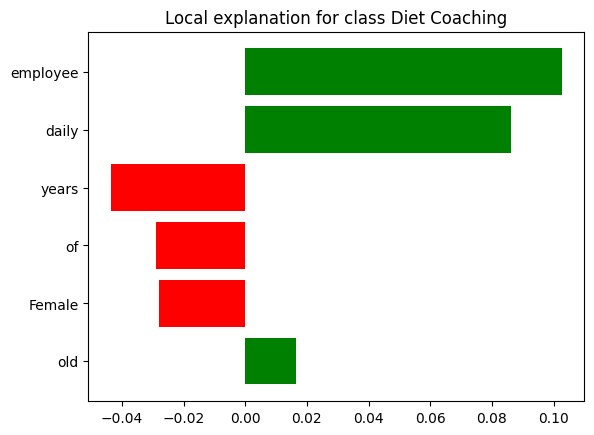


🏃 Influence des mots pour : EXERCISE PLAN


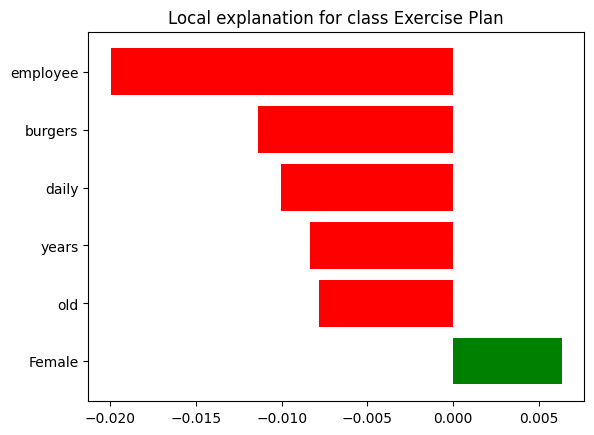

In [8]:
import torch
import numpy as np
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

# ==============================================================================
# 1. LE PONT (Fonction de prédiction simplifiée)
# ==============================================================================
def predictor(texts):
    # Tokenization
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    # Envoi sur le processeur (Mac/CPU/GPU)
    device = next(model_production.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Prédiction
    model_production.eval()
    with torch.no_grad():
        outputs = model_production(**inputs)
    
    # IMPORTANT : Sigmoid car Multi-Label (et conversion en Numpy pour LIME)
    probs = torch.sigmoid(outputs.logits).cpu().numpy()
    return probs

# ==============================================================================
# 2. EXPLICATION AVEC LIME (Version Texte)
# ==============================================================================
print("\n=== EXPLICATION AVEC LIME ===")

# Noms de vos classes
class_names = ["Vacation", "Diet Coaching", "Exercise Plan"]

# On utilise LimeTextExplainer au lieu de LimeTabularExplainer
explainer = LimeTextExplainer(class_names=class_names)

# Texte à expliquer (Prenons un exemple concret)
texte_client = "Female employee of 50 years old, eating burgers daily."

# Explication d'une instance
# num_samples=500 : On réduit à 500 essais (au lieu de 5000) pour ne pas faire ramer le PC
print(f"⏳ Analyse en cours (Version légère : 500 échantillons)...")

# On regarde spécifiquement la classe 1 (Diet) et 2 (Sport)
exp = explainer.explain_instance(
    texte_client, 
    predictor, 
    num_features=6,      # Affiche les 6 mots les plus importants
    labels=[1, 2],       # On veut comprendre Diet et Sport
    num_samples=500      # <--- C'EST ICI QU'ON SAUVE VOTRE RAM (Défaut = 5000)
)

# ==============================================================================
# 3. AFFICHAGE
# ==============================================================================

# Affichage Graphique pour Diet Coaching
print("\n🥗 Influence des mots pour : DIET COACHING")
fig = exp.as_pyplot_figure(label=1)
plt.show()

# Affichage Graphique pour Exercise Plan
print("\n🏃 Influence des mots pour : EXERCISE PLAN")
fig = exp.as_pyplot_figure(label=2)
plt.show()


=== EXPLICATION AVEC SHAP (NLP) ===
⏳ Calcul des valeurs SHAP pour : "Female employee of 50 years old, eating burgers daily."...

🔵 SHAP EXPLANATION (Version Corrigée)

--- 1. Text Plot (Analyse mot par mot) ---
Analyse pour la classe : Diet Coaching



--- 2. Bar Plot (Importance des mots) ---
Importance pour : Diet Coaching
⚠️ Erreur affichage Bar Plot : string index out of range

--- 3. Waterfall Plot (Cascade de décision) ---
Cascade pour : Diet Coaching


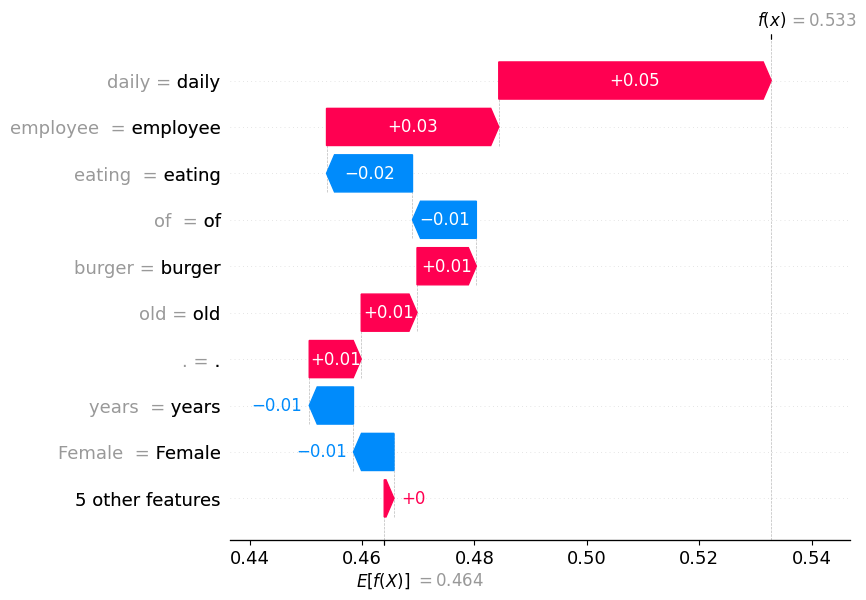

In [11]:
import shap
import torch
import numpy as np

# ==============================================================================
# 1. FONCTION DE PRÉDICTION (Le Pont)
# ==============================================================================
# On reprend le même wrapper que pour LIME
def predictor(texts):
    # Si l'entrée est une liste de listes (ce que fait parfois SHAP), on aplanit
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    
    # Tokenization
    inputs = tokenizer(
        texts, 
        return_tensors="pt", 
        truncation=True, 
        padding=True, 
        max_length=128
    )
    
    # Envoi sur le device (Mac/CPU)
    device = next(model_production.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Prédiction
    model_production.eval()
    with torch.no_grad():
        outputs = model_production(**inputs)
    
    # Probabilités (Sigmoid)
    return torch.sigmoid(outputs.logits).cpu().numpy()

# ==============================================================================
# 2. CONFIGURATION DE SHAP
# ==============================================================================
print("\n=== EXPLICATION AVEC SHAP (NLP) ===")

# On définit les noms de classes
class_names = ["Vacation", "Diet Coaching", "Exercise Plan"]

# Création du "Masker" (explique à SHAP comment couper le texte)
masker = shap.maskers.Text(tokenizer)

# Création de l'Explainer
# On utilise l'algorithme "Permutation" qui est robuste pour le texte
explainer_shap = shap.Explainer(predictor, masker, output_names=class_names)

# ==============================================================================
# 3. CALCUL (Sur un seul exemple pour économiser la RAM)
# ==============================================================================
texte_client = "Female employee of 50 years old, eating burgers daily."
print(f"⏳ Calcul des valeurs SHAP pour : \"{texte_client}\"...")

# On lance le calcul (ça peut prendre 10 à 30 secondes)
shap_values = explainer_shap([texte_client])

# ==============================================================================
# 4. VISUALISATION (Les graphiques du Prof adaptés au Texte)
# ==============================================================================

print("\n🔵 SHAP EXPLANATION (Version Corrigée)")

# On extrait l'explication pour la première phrase (index 0)
explanation = shap_values[0]

# A. TEXT PLOT (Fonctionne généralement bien)
print("\n--- 1. Text Plot (Analyse mot par mot) ---")
# Pour Diet Coaching (Index 1)
print(f"Analyse pour la classe : {class_names[1]}")
shap.plots.text(explanation[:, 1])

# B. BAR PLOT (Version Robuste)
print("\n--- 2. Bar Plot (Importance des mots) ---")
print(f"Importance pour : {class_names[1]}")
# On force l'affichage sans données brutes si ça plante, ou on simplifie
try:
    # On sélectionne uniquement la classe "Diet" pour l'affichage
    shap.plots.bar(explanation[:, 1], max_display=10)
except Exception as e:
    print(f"⚠️ Erreur affichage Bar Plot : {e}")

# C. WATERFALL PLOT (Version Robuste)
print("\n--- 3. Waterfall Plot (Cascade de décision) ---")
print(f"Cascade pour : {class_names[1]}")
try:
    # On limite l'affichage aux 10 mots les plus impactants pour éviter les soucis
    shap.plots.waterfall(explanation[:, 1], max_display=10) 
except Exception as e:
    print(f"⚠️ Erreur affichage Waterfall : {e}")